# Temperatures

Note: for this demo to work properly, you'll need to install [statsmodels](http://http://statsmodels.sourceforge.net/)

## Import libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import hypertools as hyp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels

%matplotlib inline

## Read in data

In [2]:
results=pd.read_csv('data/temperatures.csv')
locs=pd.read_csv('data/temperature_locs.csv')

## Temperature dataframe

In [3]:
results.head()

,Unnamed: 0,Year,Month,Bangkok_anomaly,Bangkok,Bombay_anomaly,Bombay,Cairo_anomaly,Cairo,Cape_Town_anomaly,...,Seoul_anomaly,Seoul,Shanghai_anomaly,Shanghai,Somalia_anomaly,Somalia,Sydney_anomaly,Sydney,Tokyo_anomaly,Tokyo
0,0,1850,1,-1.144,23.896,-1.590,22.780,-1.041,12.079,NaN,...,-0.937,-4.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1850,2,-0.599,26.431,-0.697,23.713,-1.371,13.399,NaN,...,-0.594,-2.284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1850,3,-0.753,28.097,-0.719,25.301,-1.499,16.041,NaN,...,0.119,3.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1850,4,-1.297,28.633,-1.194,26.426,-1.418,19.862,NaN,...,-2.896,7.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1850,5,-1.446,27.994,-1.250,27.850,-2.427,22.613,NaN,...,-1.209,14.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Locations dataframe

In [4]:
print(locs)

    Unnamed: 0         City    Lat    Long
0            0      Bangkok  13.66   99.91
1            0       Bombay  18.48   72.68
2            0        Cairo  29.74   31.38
3            0    Cape_Town -32.95   18.19
4            0      Chicago  42.59  -87.27
5            0     Istanbul  40.99   29.82
6            0       London  52.24   -0.00
7            0  Los_Angeles  34.56 -118.70
8            0       Mexico  20.09  -98.96
9            0     Montreal  45.81  -72.69
10           0       Moscow  55.45   36.85
11           0     New_York  40.99  -74.56
12           0         Rome  42.59   13.09
13           0     Santiago -32.95  -69.89
14           0    Sao_Paulo -23.31  -46.31
15           0        Seoul  37.78  126.10
16           0     Shanghai  31.35  120.63
17           0      Somalia   2.41   45.80
18           0       Sydney -34.56  151.78
19           0        Tokyo  36.17  139.23


## Clean up NAs and convert to numpy array to pass into hyperplot

In [5]:
results = results.dropna()
temps = results.as_matrix(locs['City'].as_matrix())
years = results.as_matrix(['Year'])
month = results.as_matrix(['Month'])

## Static 3D image: plot the high-dimensional data in a low dimensional space

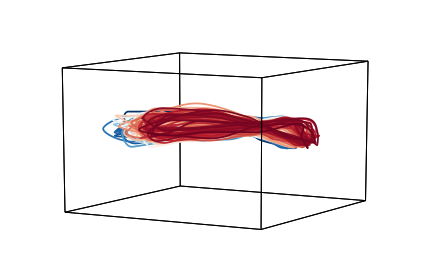

In [6]:
geo = hyp.plot(temps, group=years.flatten(), palette='RdBu_r', normalize='across')

## Static 2D image

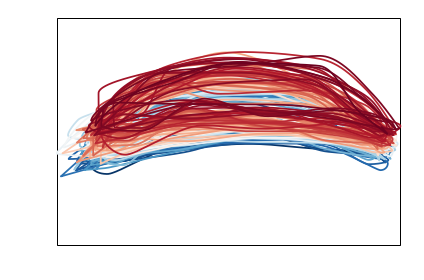

In [7]:
geo.plot(ndims=2)

## Color Bar

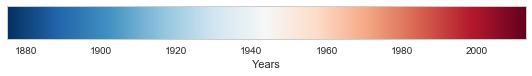

In [8]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=1875, vmax=2013)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Years')
plt.show()

## Lowess predictions of PCA values by year

In [9]:
sns.set_style('darkgrid')
sns.set_palette(palette='muted')
reduced_data = hyp.reduce(temps, reduce='PCA', ndims = 3)

results['PCA 1'] = reduced_data[:,0]
results['PCA 2'] = reduced_data[:,1]
results['PCA 3'] = reduced_data[:,2]

PCA1_df = results[['Year', 'PCA 1']]
PCA2_df = results[['Year', 'PCA 2']]
PCA3_df = results[['Year', 'PCA 3']]

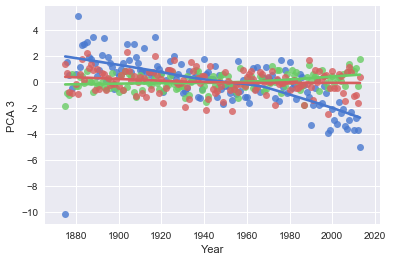

In [10]:
sns.regplot(x='Year', y='PCA 1', data=PCA1_df.groupby(['Year']).mean().reset_index(), lowess=True)
sns.regplot(x='Year', y='PCA 2', data=PCA2_df.groupby(['Year']).mean().reset_index(), lowess=True)
sns.regplot(x='Year', y='PCA 3', data=PCA3_df.groupby(['Year']).mean().reset_index(), lowess=True)
plt.show()

## Lowess predictions of PCA values by  average yearly temperature

In [11]:
temp_PCA = pd.DataFrame()
temp_PCA['ave_temp'] = results.groupby(['Year']).mean()[locs['City']].mean(axis=1)

In [12]:
temp_PCA = temp_PCA.join(PCA1_df.groupby(['Year']).mean(), how = 'outer')
temp_PCA = temp_PCA.join(PCA2_df.groupby(['Year']).mean(), how = 'outer')
temp_PCA = temp_PCA.join(PCA3_df.groupby(['Year']).mean(), how = 'outer')

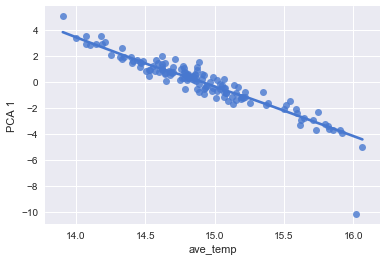

In [13]:
sns.regplot(x='ave_temp', y='PCA 1', data = temp_PCA, lowess=True)
plt.show()

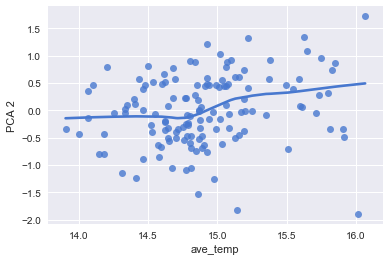

In [14]:
sns.regplot(x='ave_temp', y='PCA 2', data = temp_PCA, lowess=True)
plt.show()

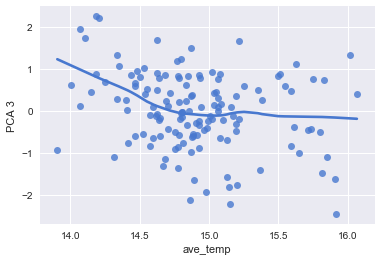

In [15]:
sns.regplot(x='ave_temp', y='PCA 3', data = temp_PCA, lowess=True)
plt.show()

## Linear regression predictions of PCA values by month

In [16]:
PCA1_df = results[['Month', 'Year', 'PCA 1']]
PCA2_df = results[['Month', 'Year', 'PCA 2']]
PCA3_df = results[['Month', 'Year', 'PCA 3']]

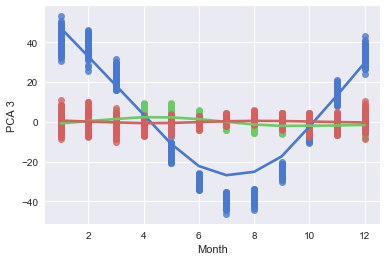

In [17]:
sns.regplot(x='Month', y='PCA 1', data=PCA1_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
sns.regplot(x='Month', y='PCA 2', data=PCA2_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
sns.regplot(x='Month', y='PCA 3', data=PCA3_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
plt.show()

In [18]:
temps_locs = pd.DataFrame()
temps_locs = results.groupby(['Year']).mean()[locs['City']].reset_index()

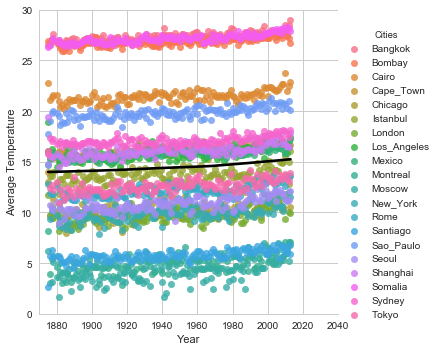

In [19]:
meltCov = pd.melt(temps_locs,id_vars=['Year'], var_name='Cities', value_name='Average Temperature')
sns.set(style="whitegrid")
sns.set_palette(palette='muted')
g = sns.lmplot(x = 'Year', y = 'Average Temperature', hue="Cities", data = meltCov, fit_reg=False, legend_out=True)
regplot = sns.regplot(x = 'Year', y = 'Average Temperature', data = meltCov, lowess = True, scatter=False, ax=g.axes[0, 0], color='k')
regplot.set(ylim=(0, 30), xlim=(1870,2040))
plt.show()